# Modelo ML Supervisado detector Anomalias en intraestructura en la nube

# I. Descripción del problema e inspección del conjunto de datos

## 1. Descripción del problema y conjuto de datos

El objetivo es identificar automáticamente, basándose en un conjunto de métricas operacionales (como el uso de CPU, memoria, tráfico de red, y consumo de energía), cuándo una VM se está comportando de manera anómala o inusual, en lugar de su patrón de comportamiento normal.

**Finalidad**: Este tipo de detección es crucial para la monitorización del rendimiento, el mantenimiento predictivo, y la fiabilidad general de los servicios en la nube, permitiendo identificar fallos de hardware, software o posibles incidentes de seguridad de forma temprana.

**Aproximación**: El dataset proporciona una etiqueta binaria ("Anomaly status") para cada conjunto de métricas, lo que permite el desarrollo y la evaluación de modelos de Machine Learning supervisado para clasificar si un estado de la VM es normal o anómalo

El conjunto de datos proviene de un dataset de Kanggle https://www.kaggle.com/datasets/sandhyapeesara/cloud-anomaly-data

### Descripción de Variables

| Variable | Tipo de Dato (Implícito) | Descripción Mejorada |
| :--- | :--- | :--- |
| **vm\_id** | Categórico / ID | **Identificador único** de la Máquina Virtual (VM) en el entorno de la nube. Permite rastrear el rendimiento individual de cada instancia. |
| **timestamp** | Temporal | **Marca de tiempo** exacta de la medición. Es fundamental para el análisis de **series de tiempo** y la detección de patrones temporales o estacionalidad. |
| **cpu\_usage** | Numérico (Porcentaje) | **Utilización del Procesador Central (CPU)**, expresada como un porcentaje (0-100%). Mide la carga de trabajo de la VM. |
| **memory\_usage** | Numérico (Porcentaje) | **Utilización de la Memoria RAM**, expresada como un porcentaje (0-100%). Indica la cantidad de memoria activa consumida por los procesos. |
| **network\_traffic** | Numérico | **Volumen de Tráfico de Red** (entrada/salida) de la VM. Medido en una escala relativa (0-1000); podría representar bytes/segundo o paquetes/segundo. |
| **power\_consumption** | Numérico | **Consumo de Energía** de la VM en la unidad de tiempo. Medido en una escala relativa (0-500); la unidad física podría ser Vatios (W). |
| **num\_executed\_instructions** | Numérico (Contador) | **Número de Instrucciones** ejecutadas por la CPU durante el intervalo de medición. Mide la productividad computacional. |
| **execution\_time** | Numérico | **Tiempo de Ejecución** de las tareas o procesos en la VM. Medido en una escala relativa (0-100); podría representar milisegundos o un tiempo de respuesta normalizado. |
| **energy\_efficiency** | Numérico (Ratio) | **Eficiencia Energética**. Un valor normalizado entre 0 y 1, que generalmente se calcula como una razón entre el rendimiento (ej. instrucciones ejecutadas) y el consumo de energía. |
| **task\_type** | Categórico | **Tipo de Tarea** principal que se está ejecutando en la VM en ese momento. Categorías clave: **'io'** (Intensiva en Entrada/Salida), **'network'** (Intensiva en Red), **'other'**. |
| **task\_priority** | Categórico Ordinal | **Nivel de Prioridad** asignado a la tarea en curso. Categorías: **'low'** (Baja), **'high'** (Alta), **'other'** (Otras o media/variable). |
| **task\_status** | Categórico | **Estado Actual de la Tarea** medida. Categorías: **'waiting'** (En espera de recursos), **'running'** (Actualmente en ejecución), **'other'** (Otros estados, como completada o fallida). |
| **Anomaly status** | Binario (Target) | **Estado de Anomalía**. Esta es la **variable objetivo** (`target`). Un valor de **1** indica que el comportamiento de la VM se considera **Anómalo**, y **0** indica un comportamiento **Normal**. |

### Contenido Dataset

### Import Libraries

In [1]:
# Install libraries
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler


C:\Users\ESTUDIANTE\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Dataset

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Cloud_Anomaly_Dataset.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "sandhyapeesara/cloud-anomaly-data",
  file_path,
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277570 entries, 0 to 277569
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   vm_id                      249595 non-null  object 
 1   timestamp                  277570 non-null  object 
 2   cpu_usage                  250130 non-null  float64
 3   memory_usage               249775 non-null  float64
 4   network_traffic            249725 non-null  float64
 5   power_consumption          250018 non-null  float64
 6   num_executed_instructions  249637 non-null  float64
 7   execution_time             249960 non-null  float64
 8   energy_efficiency          249616 non-null  float64
 9   task_type                  249580 non-null  object 
 10  task_priority              249674 non-null  object 
 11  task_status                249621 non-null  object 
 12  Anomaly status             277570 non-null  int64  
dtypes: float64(7), int64(1), obje

#### Resumen Estadistico

In [3]:
df.describe()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,Anomaly status
count,250130.000000,249775.000000,249725.000000,250018.000000,249637.000000,249960.000000,249616.000000,277570.000000
mean,50.013258,49.967249,500.554083,249.987238,5002.490284,50.011964,0.500369,0.059999
std,28.895806,28.879090,288.787794,144.662676,2882.806422,28.837634,0.288547,0.237486
min,0.000071,0.000016,0.002542,0.000802,0.000000,0.000172,0.000004,0.000000
25%,24.880023,24.965105,250.298114,124.199907,2506.000000,25.098016,0.250375,0.000000
50%,50.023806,49.912051,500.736963,250.397212,5000.000000,50.005593,0.500834,0.000000
75%,75.097896,74.960052,750.720026,375.485305,7499.000000,75.043715,0.750112,0.000000
max,99.999171,99.999907,999.998686,499.998819,9999.000000,99.998831,0.999994,1.000000


### Identificación de datos unicos

In [4]:
df.nunique()

vm_id                        249595
timestamp                     44552
cpu_usage                    250128
memory_usage                 249774
network_traffic              249724
power_consumption            250010
num_executed_instructions     10000
execution_time               249957
energy_efficiency            249591
task_type                         3
task_priority                     3
task_status                       3
Anomaly status                    2
dtype: int64

Preliminarmente no se puede descartar ningura variable por ser constate

#### Identificación de valores nulos

In [5]:
df.isna().sum()

vm_id                        27975
timestamp                        0
cpu_usage                    27440
memory_usage                 27795
network_traffic              27845
power_consumption            27552
num_executed_instructions    27933
execution_time               27610
energy_efficiency            27954
task_type                    27990
task_priority                27896
task_status                  27949
Anomaly status                   0
dtype: int64

Se debe tener el cuenta las variables 'cpu_usage', 'memory_usage', 'network_traffic', 'power_comsuption', 'num_excecuted_instrucitons', 'excecution_time', energy_efficiency','task_type', 'trask_priority'y task_status' que cuentan datos nulos, donde se debe aplicacar una estrategía de corrección de los mismos

### Histogramas y diagramas de cajas para valores numericos

In [6]:
# Variables numéricas para análisis
numerical_vars = ['cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption', 'num_executed_instructions',
'execution_time', 'energy_efficiency']


#### Histogramas

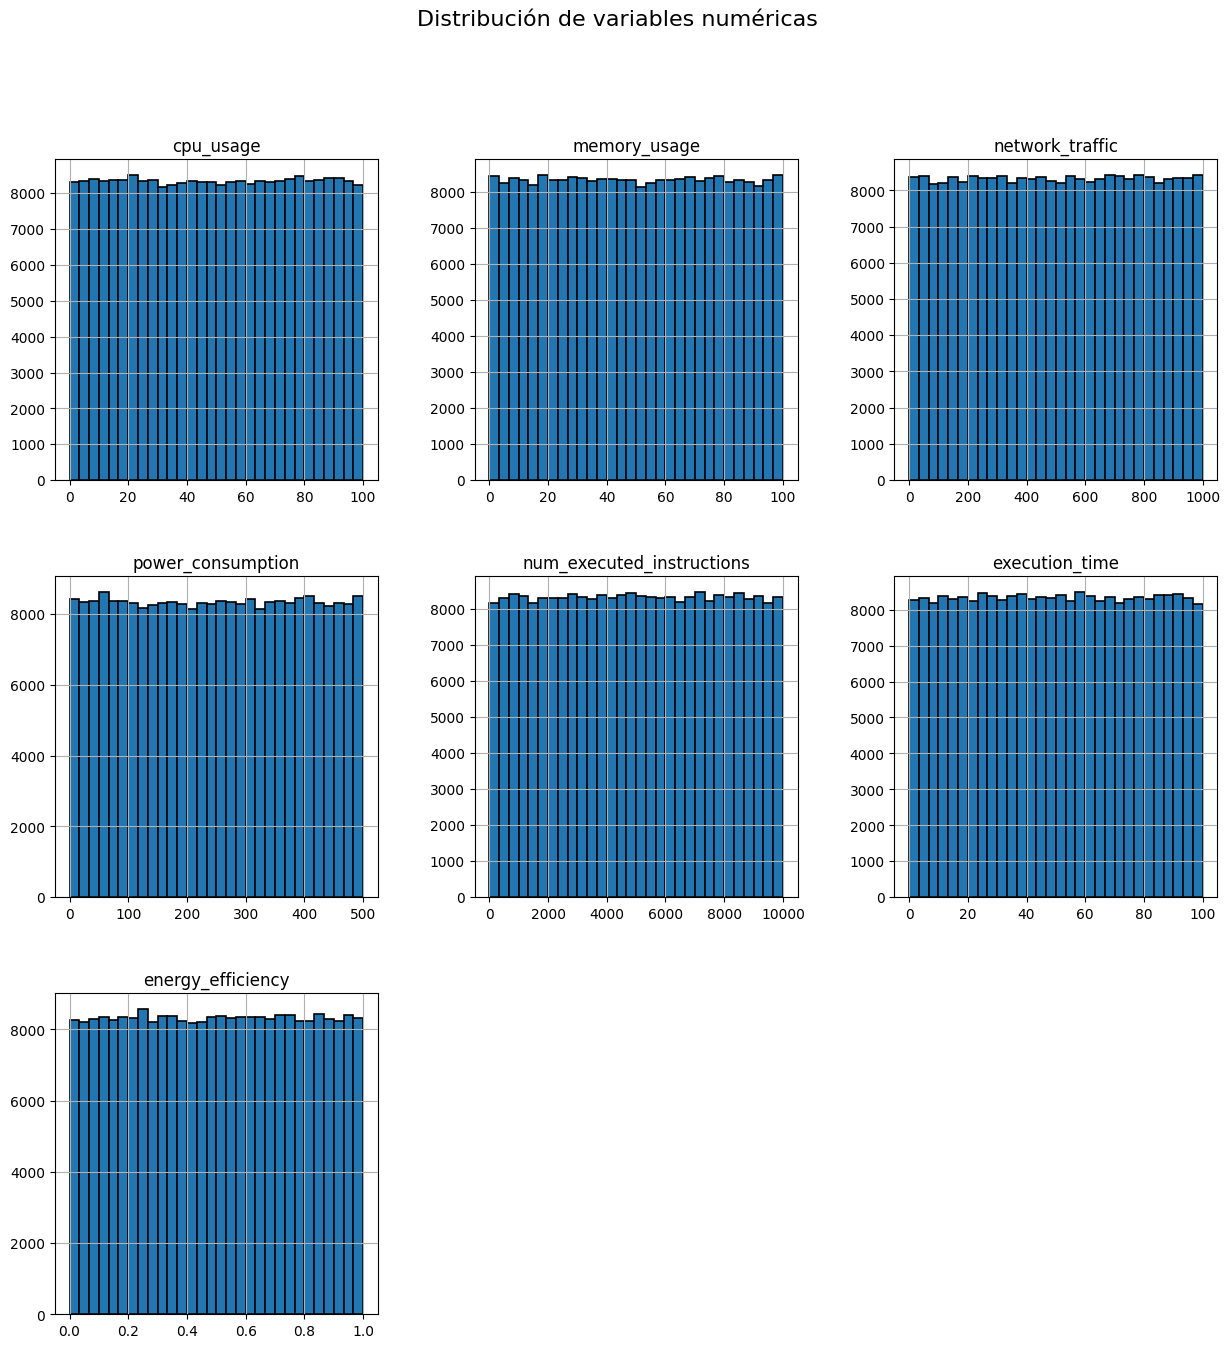

In [7]:


# Generar histogramas
df_numeric = df.select_dtypes(include=['float64'])

df_numeric.hist(edgecolor='black', linewidth=1.2, bins=30)
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.suptitle('Distribución de variables numéricas', fontsize=16)
plt.show()



Basado en los diagramas generados, podemos observar que todos siguen una distribución uniforme. Esto significa que todos los valores dentro del rando de la variable tienen aproximadamente la misma probabilidad de ocurrir. Lo que implica analisar las variables desde otro punto de vista

#### Diagramas de cajas y bigotes

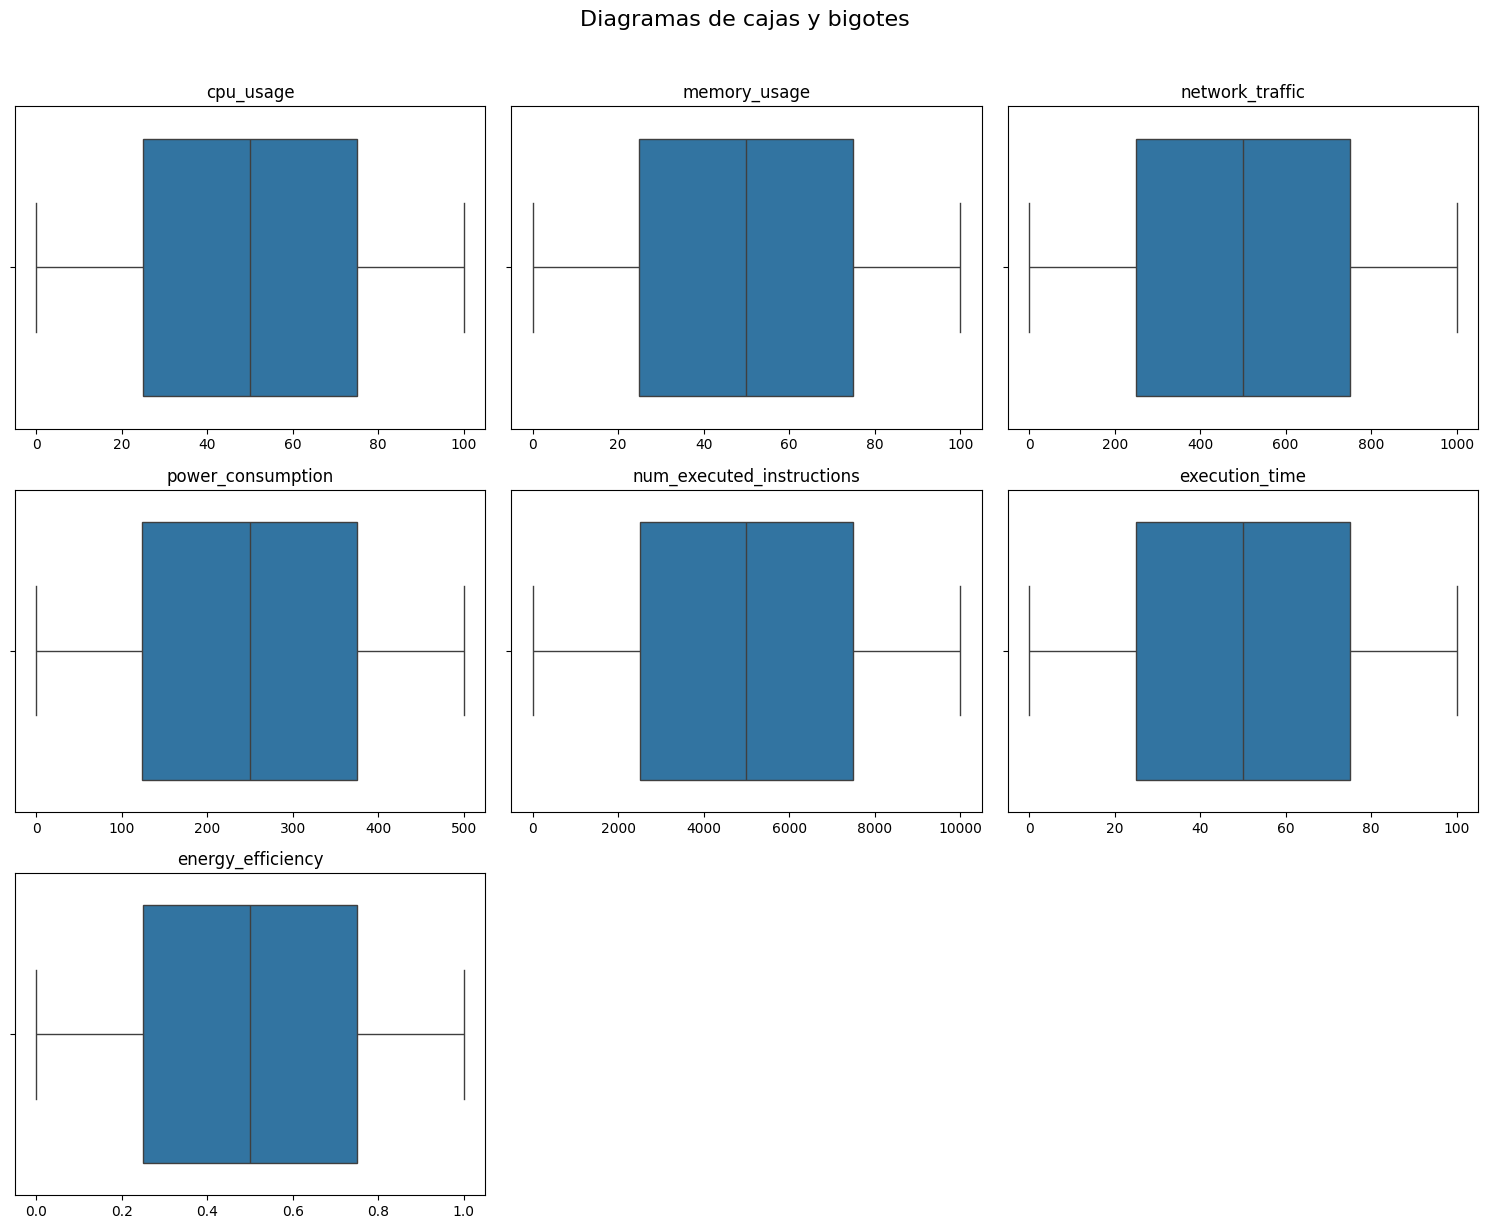

In [8]:

df_numeric = df.select_dtypes(include=['float64'])
numerical_vars = df_numeric.columns
n_vars = len(numerical_vars)

n_cols = 3 
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    ax = axes[i]
    sns.boxplot(x=df[var], ax=ax)
    ax.set_title(f'{var}')
    ax.set_xlabel('') # Opcional: limpia la etiqueta x para no ser redundante

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Diagramas de cajas y bigotes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Podemos observar que no hay puntos fuera de los bigotes, que los bigotes lleguen a los extremas es concecuencia de la distribución uniforme

Aunque la distribuición total parezca uniforme, es muy probable que las distribuciones para los datos normales y anómalos sean diferentes entre sí.

Por tanto deberiamos visualizar por Categoría de Anomalía

### Visualizar por Categoría de Anomalía
Generar los gráficos, pero esta vez, separando los datos por el valor de la columna **Anomaly status**. Esto nos permitirá comparar la distribucón de los casos normales vs los casos anómalos

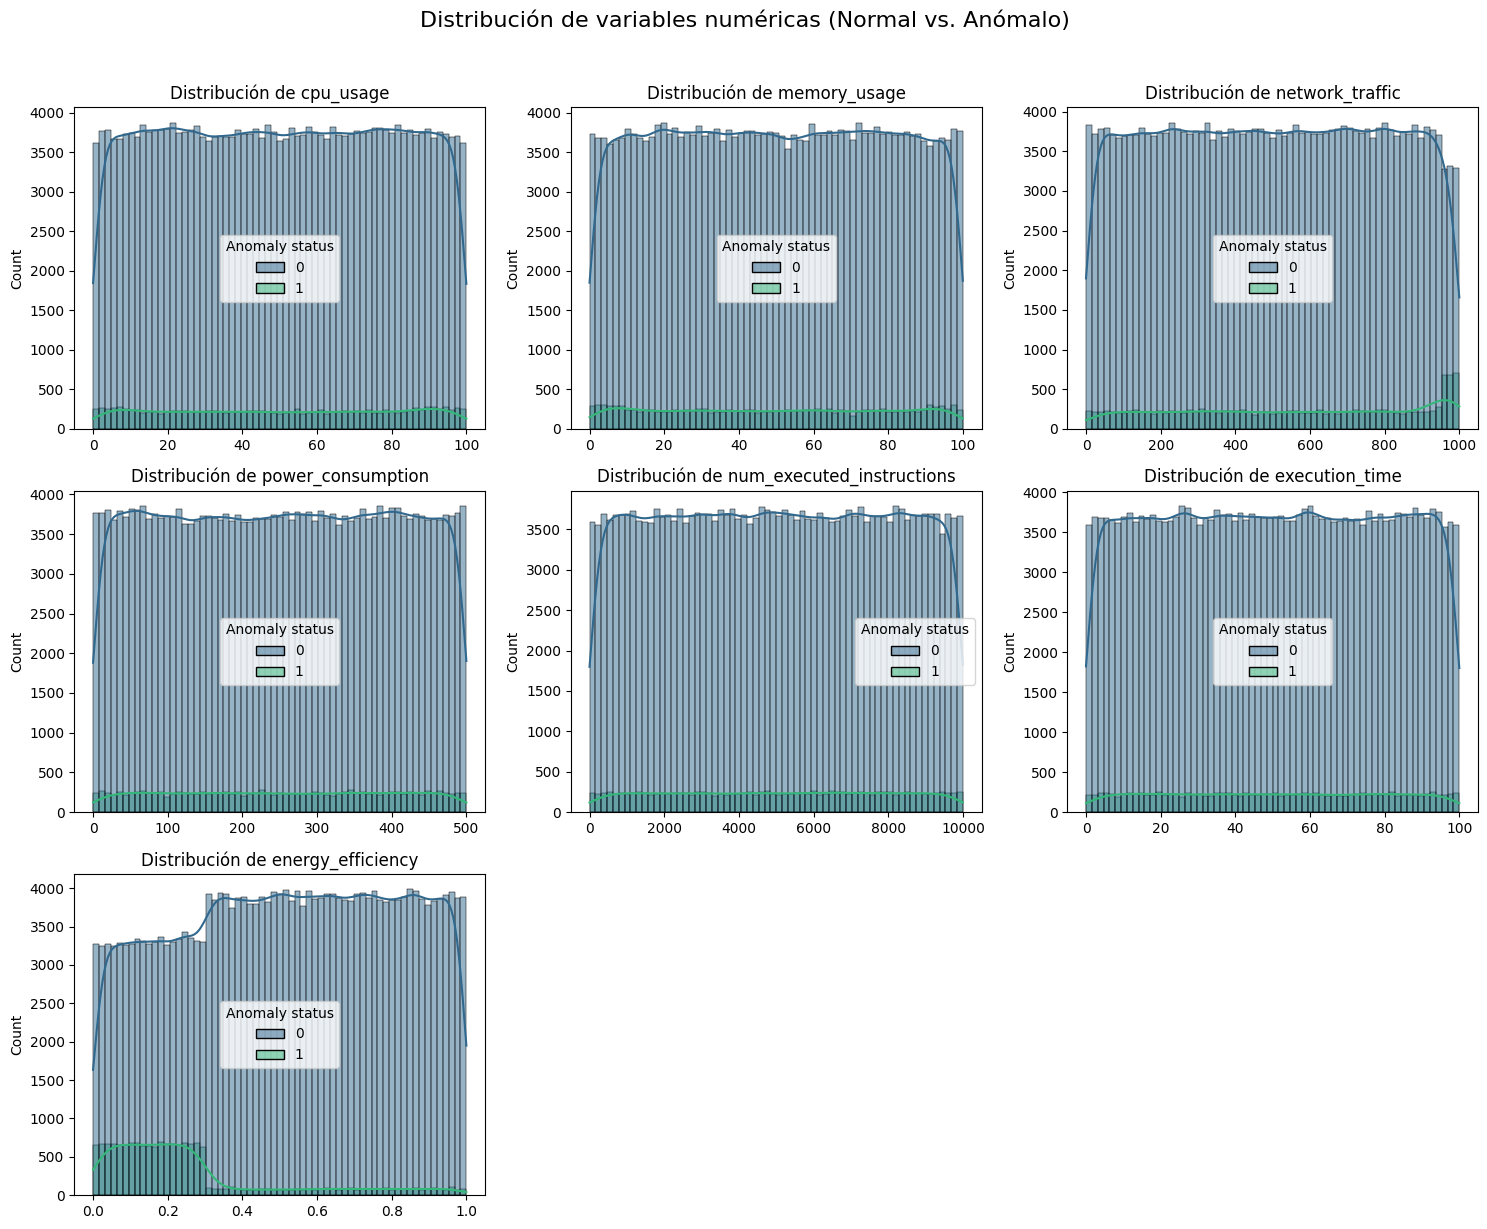

In [9]:
df_numeric = df.select_dtypes(include=['float64'])
numerical_vars = df_numeric.columns
n_vars = len(numerical_vars)

n_cols = 3 
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    ax = axes[i]
    sns.histplot(data=df, x=var, hue='Anomaly status', kde=True, palette='viridis', ax=ax)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel('') # Opcional: limpia la etiqueta x para no ser redundante

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribución de variables numéricas (Normal vs. Anómalo)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### Análisis de Distribuciones por Estado de Anomalía

Al visualizar las distribuciones de las variables numéricas segmentadas por la variable objetivo (Anomaly status), se
revelan patrones cruciales para la construcción del modelo:

* Desbalance de Clases Significativo: Se confirma una característica común en problemas de detección de anomalías: un
    fuerte desbalance de clases. El conjunto de datos contiene una proporción considerablemente mayor de instancias
    normales (0) en comparación con las anómalas (1). Este factor es crítico y deberá ser gestionado antes de la fase de
    entrenamiento mediante balanceo

* Patrón en `network_traffic`: Esta variable demuestra ser un fuerte indicador de anomalías. Se observa una alta
    concentración de instancias anómalas en el rango de valores altos (aproximadamente 950-1000). Por el contrario, las
    instancias normales son muy infrecuentes en este mismo rango, lo que sugiere que un tráfico de red excepcionalmente
    alto es un síntoma claro de un comportamiento anómalo.

* Patrón en `energy_efficiency`: De manera similar, la eficiencia energética es un predictor clave. Los valores bajos de
    energy_efficiency (en el intervalo de 0.0 a 0.3) están fuertemente correlacionados con la ocurrencia de anomalías. Las
    instancias normales, en cambio, tienden a presentar una eficiencia energética más alta y muestran una frecuencia muy
    baja en este rango.

#### Conclusión del Análisis Visual:

El análisis exploratorio revela que, aunque las distribuciones generales de las variables pueden parecer uniformes,
existen diferencias claras y medibles en las distribuciones cuando se separan por clase (normal vs. anómela). Variables
como network_traffic y energy_efficiency son especialmente prometedoras y probablemente tendrán un alto poder predictivo
en los modelos de machine learning que se desarrollarán

### Visualizacón de Variables Categóricas
Para entender si las difenretes categorías se relacionan con el estado de anomalía

Para las variables categóricas como `task_type`, `task_priority` y `task_status`, los diagramas de barras son la herramienta ideal. Nos permitiran ver la frecuancia absoluta o relativa de cada categoría

Al igual que el analisis previo, es fundamental analizar estas distrivuciones separados por el `anomaly_status` para identificar si ciertas categorías están más asociadas con el comportamietno anómalo

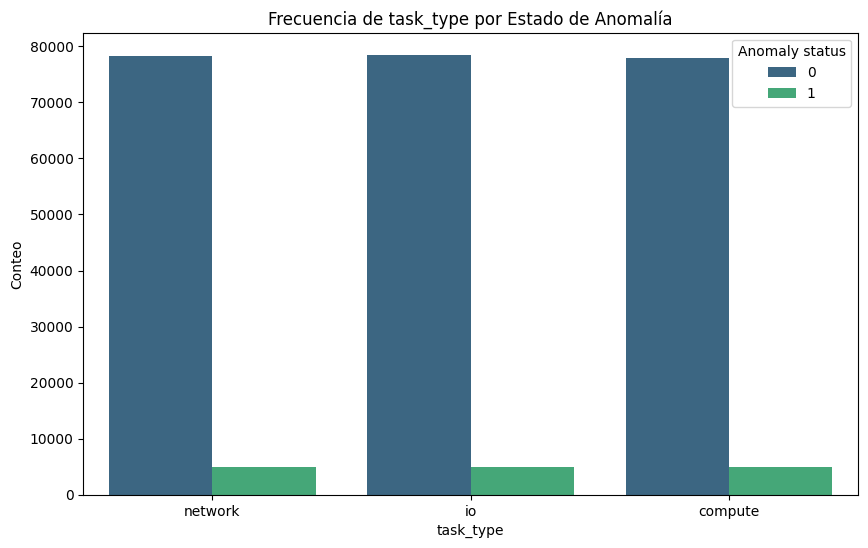

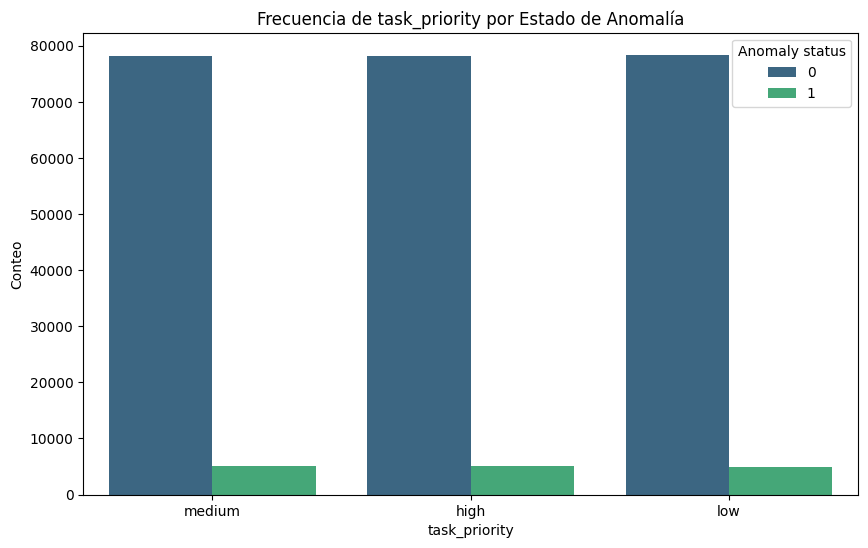

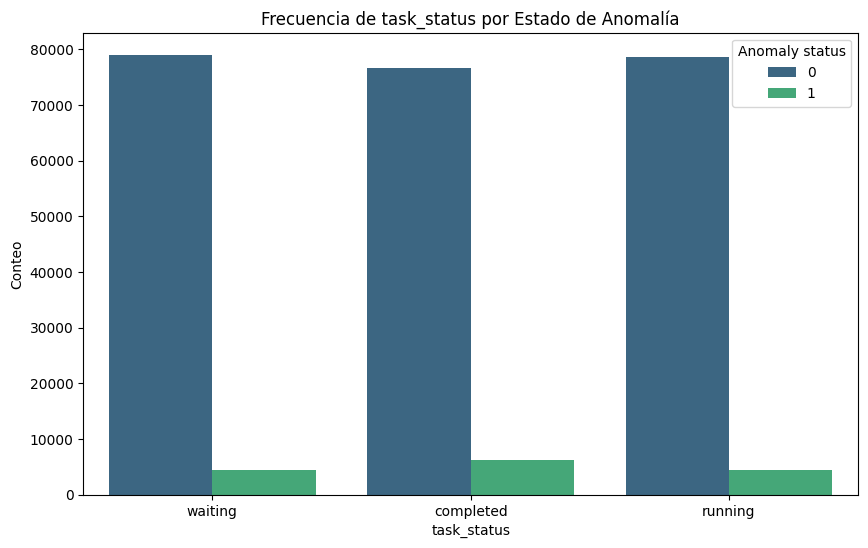

In [10]:
# Seleccionar las variables categóricas a visualizar
categorical_vars = ['task_type', 'task_priority', 'task_status']

# Generar diagramas de barras para cada variable categórica, separados por Anomaly status
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=var, hue='Anomaly status', palette='viridis')
    plt.title(f'Frecuencia de {var} por Estado de Anomalía')
    plt.xlabel(var)
    plt.ylabel('Conteo')
    plt.show()

- Análisis de `task_status`:
    - En el caso de las anomalías, se observa una frecuencia ligeramente superior de instancias en el estado completed en
       comparación con los estados running y waiting, los cuales presentan frecuencias muy similares entre sí.
    - Para las instancias normales, la categoría completed exhibe una frecuencia marginalmente inferior a las otras dos
      categorías (running y waiting).
    - Implicación: Este patrón sugiere que, aunque el estado completed podría parecer benigno, una proporción
      relativamente mayor de anomalías se manifiesta en este estado. Esto indica que el task_status podría ser un factor
      discriminatorio, aunque sutil, para la detección de anomalías, y su interacción con otras variables podría ser
      relevante.

- Análisis de `task_type` y `task_priority`: Para estas variables, la distribución de frecuencias de sus categorías es
    similar tanto para las instancias normales como para las anómalas, manteniendo la proporción general de desbalance de
    clases observada en el dataset. Esto sugiere que, de forma aislada, task_type y task_priority no presentan un poder
    discriminatorio directo significativo para identificar anomalías. Sin embargo, podrían ser relevantes en combinación
    con otras características o para contextualizar los eventos.



### Analisis de correlación
El análisis de correlación es un paso crucial para entender las relaciones entre las variables numéricas, y es fundamental para la selección de características

#### Analisis de correlación con Mapa de Calor

Una Matriz de correlación nos mmostrarás el coeficiente de correlación (Pearson) entre cada par de variables númericas. Un mapa de calor es una excelente manera de visualizar esta matriz

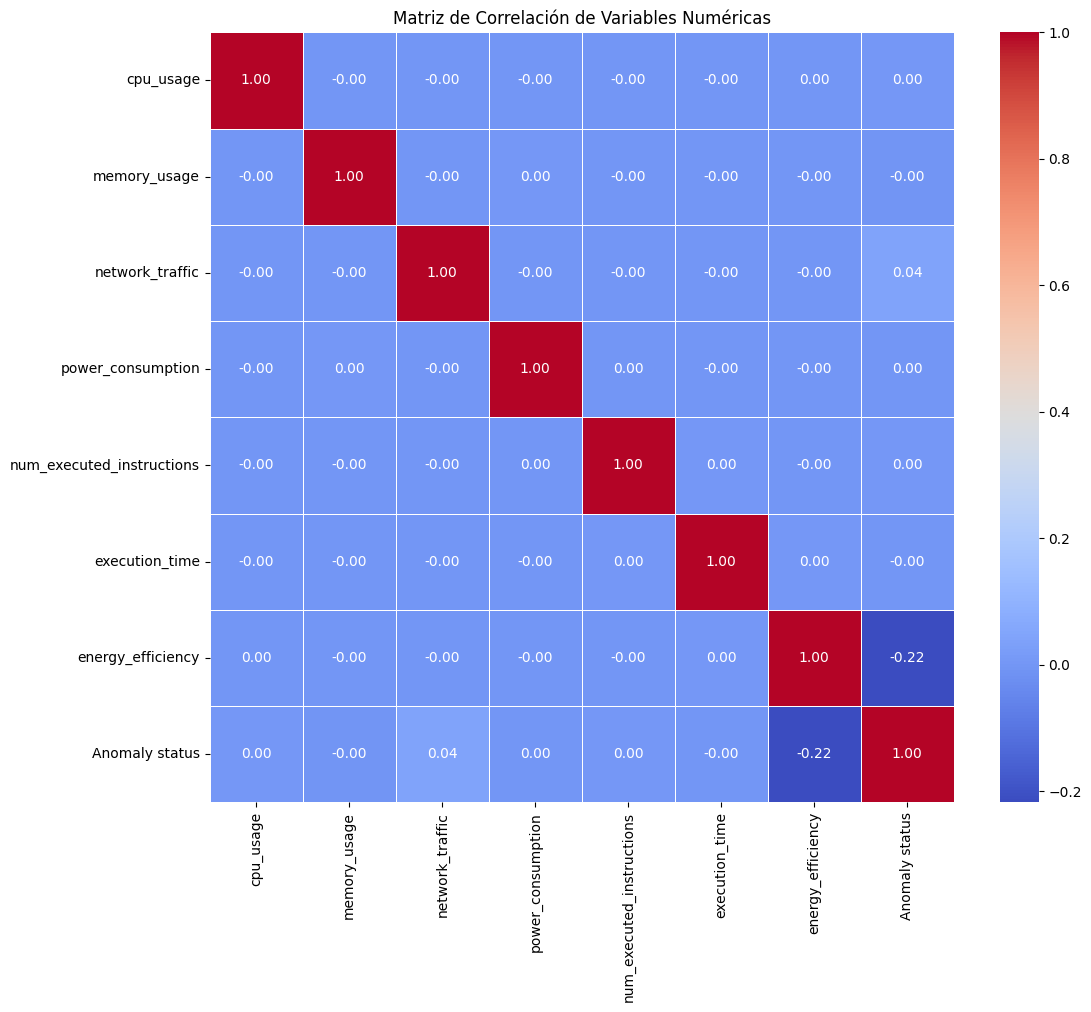

In [11]:
numerical_vars_for_corr = [
    'cpu_usage',
    'memory_usage',
    'network_traffic',
    'power_consumption',
    'num_executed_instructions',
    'execution_time',
    'energy_efficiency',
    'Anomaly status' # Incluimos la variable objetivo
]

# Calcular la matriz de correlación
correlation_matrix = df[numerical_vars_for_corr].corr()

# Generar el mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

#### Análisis de Correlación

El análisis del mapa de calor revela los siguientes puntos clave:

- Principal Predictor Lineal (`energy_efficiency`): La variable energy_efficiency muestra la correlación más
    significativa con Anomaly status, con un coeficiente de -0.22. Esta correlación negativa moderada indica que una menor
    eficiencia energética está linealmente asociada con una mayor probabilidad de anomalía. Este resultado cuantitativo
    refuerza los hallazgos del análisis visual, donde se observó una alta frecuencia de anomalías en los rangos bajos de
    esta variable.

- Correlación Débil pero Relevante (`network_traffic`): La variable network_traffic presenta una correlación positiva
    débil de 0.04 con la variable objetivo. Aunque el valor es bajo, es el segundo más relevante y sugiere que un aumento
    en el tráfico de red tiene una ligera asociación lineal con la ocurrencia de anomalías, lo cual también es consistente
    con el análisis visual previo.

- Baja Correlación de Otras Variables: Las demás variables numéricas (cpu_usage, memory_usage, power_consumption, etc.)
    exhiben coeficientes de correlación muy cercanos a cero con Anomaly status. Esto implica que no poseen una relación
    lineal fuerte con la variable objetivo de forma individual.

- Ausencia de Multicolinealidad: Se observa una correlación extremadamente baja entre las variables predictoras. La
    ausencia de multicolinealidad es beneficiosa, ya que indica que las características son en gran medida independientes y
    no aportan información redundante, lo que simplifica la interpretación del modelo.

#### Conclusión del Análisis de Correlación:

El análisis de correlación posiciona a energy_efficiency y, en menor medida, a network_traffic como las características
numéricas con mayor poder predictivo lineal. Estos hallazgos serán fundamentales para la etapa de selección de
características y la construcción del modelo.


# II. Diseño de Experimentos y Recolección de Resultados

## 3. Estrategia de Preparación de Datos.

#### Corrigiendo datos faltantes

La estrategía que consideramos para rellenar los datos faltantes es por la media, ya que en analisis previo observamos un comportameindo uniforme, la mediana es una medida robusta para este caso, ya que no se va a ver afectada por valores extremos

Para las variables categóricas (task_type, task_priority, task_status), no podemos calcular una media o mediana. La estrategia
estándar y más lógica es usar la moda, que es el valor que aparece con más frecuencia en la columna. De esta manera, asignamos la
categoría más probable al dato faltante.


In [12]:
# Imputación de valores nulos para variables numéricas con la mediana
numerical_cols_with_na = ['cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption', 'num_executed_instructions',
'execution_time', 'energy_efficiency']

for col in numerical_cols_with_na:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Imputación de valores nulos para variables categóricas con la moda
categorical_cols_with_na = ['task_type', 'task_priority', 'task_status']

for col in categorical_cols_with_na:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)


df.isna().sum()

vm_id                        27975
timestamp                        0
cpu_usage                        0
memory_usage                     0
network_traffic                  0
power_consumption                0
num_executed_instructions        0
execution_time                   0
energy_efficiency                0
task_type                        0
task_priority                    0
task_status                      0
Anomaly status                   0
dtype: int64

#### Codificación de variables categoricas
Los modelos de ML no pueden trabajar directamente con texto (como 'low', 'high', 'io'). Necesitamos convertir todas las variables a formato numérico.


Tenemos dos tipos de variables categóricas que requieren un tratamiento diferente:

A. Variables Nominales (`task_type`, `task_status`)
Estas no tienen un orden inherente. Usaremos One-Hot Encoding, que crea nuevas columnas binarias (0 o 1) para cada categoría.


In [13]:

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=['task_type', 'task_status'], drop_first=True)

B. Variable Ordinal (`task_priority`)
Esta variable sí tiene un orden ('low' < 'other' < 'high'). Aquí, asignaremos un número a cada categoría para preservar esa jerarquía.

In [14]:

# Definir el orden y mapear
priority_mapping = {'low': 0, 'medium': 1, 'high': 2}
df['task_priority'] = df['task_priority'].map(priority_mapping)
print(df['task_priority'].unique())

[1 2 0]


#### Separar nuestras variable objetivo y variables caracteristicas

Separaremos nuestro DataFrame en la variable objetivo (y) que en nuestro caso es `Anomaly status` y las caracteristicas (x) que usaremos para la predicción. También eliminaremos las columnas que no son útiles para el modelo, como `vm_id` y `timestamp`

In [15]:
# 'y' es nuestra variable objetivo
y = df['Anomaly status']

# 'X' son todas las demás columnas, excepto las que no aportan información predictiva
X = df.drop(columns=['Anomaly status', 'vm_id', 'timestamp'])

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (277570, 12)
Dimensiones de y: (277570,)


#### División en Conjuntos de Entrenamiento y Prueba

Dividimos los datos en un conjunto para entrenar el modelo y otro para evaluarlo de forma imaparcial

In [16]:

# Dividir los datos (70% entrenamiento, 30% prueba)
# stratify=y asegura que la proporción de anomalías sea la misma en ambos conjuntos, lo cual es clave en datasets desbalanceados.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)

Tamaño de X_train: (194299, 12)
Tamaño de X_test: (83271, 12)


#### Balanceo de clases


#### Nota Metodológica Crucial: El Orden Correcto para el Balanceo de Datos

Una de las decisiones más críticas en este proyecto fue realizar el balanceo de clases (con SMOTE y RUS) después de dividir los datos en conjuntos
de entrenamiento y prueba, y no antes. Esta elección no es arbitraria y es fundamental para garantizar que la evaluación de nuestros modelos sea
realista y no esté artificialmente inflada. A continuación, se detalla el porqué.

##### El Enfoque Correcto (El que se utilizó)

1. División Primero (`train_test_split`): Se separa el conjunto de datos en un conjunto de entrenamiento y uno de prueba. El conjunto de prueba se
    "guarda" y no se toca. Este conjunto simula los datos nuevos y no vistos que el modelo encontrará en un entorno real.

2. Balanceo Después (Solo en el conjunto de entrenamiento): Las técnicas de balanceo, como SMOTE, se aplican únicamente al conjunto de
    entrenamiento (X_train, y_train).

¿Por qué es lo correcto?

El objetivo del balanceo es enseñarle al modelo a reconocer mejor la clase minoritaria durante la fase de entrenamiento. Al sobremuestrear solo los 
datos de entrenamiento, le damos al modelo una visión más equilibrada para que aprenda los patrones de las anomalías sin sesgarse hacia la clase
mayoritaria. Sin embargo, el modelo debe ser evaluado en un conjunto de prueba que mantenga la distribución de clases del mundo real (es decir,
desbalanceado), para medir de forma honesta su rendimiento en un escenario práctico.

##### El Enfoque Incorrecto y el Riesgo de "Fuga de Datos" (Data Leakage)

Consideremos qué habría pasado si hubiéramos invertido el orden:

1. Balanceo Primero (Sobre todo el dataset): Se aplica SMOTE a todo el conjunto de datos (X, y). SMOTE funciona creando "muestras sintéticas" de la
    clase minoritaria. Para hacerlo, mira las muestras minoritarias existentes y genera nuevas muestras que son interpolaciones entre una muestra y
    sus vecinos más cercanos.

2. División Después: Luego, este nuevo dataset, ahora artificialmente balanceado, se divide en entrenamiento y prueba.

¿Cuál es el problema? ¡La Fuga de Datos!
Al crear muestras sintéticas antes de la división, es casi seguro que se genere la siguiente situación:

* Una muestra sintética creada por SMOTE termina en el conjunto de prueba.
* Esta muestra sintética es, por definición, muy similar (una interpolación) a las muestras originales que se usaron para crearla.
* Es muy probable que esas muestras originales "padres" hayan terminado en el conjunto de entrenamiento.

En esencia, el conjunto de prueba ya no es "nuevo y no visto". Contiene información derivada directamente de los datos de entrenamiento. El modelo,
durante la evaluación, estará viendo "ecos" o "copias" de lo que ya vio al entrenar.

La Consecuencia: Un Sesgo Optimista y Falsas Expectativas

Este fenómeno de fuga de datos conduce a que las métricas de rendimiento en el conjunto de prueba (accuracy, recall, F1-score) sean irrealmente
altas. El modelo parecerá ser mucho mejor de lo que realmente es, porque en la práctica no está generalizando a datos nuevos, sino reconociendo
información que ya se le "filtró".

Si un modelo entrenado de esta manera se implementara en producción, su rendimiento caería drásticamente, ya que los datos del mundo real son
verdaderamente nuevos y no contienen estas pistas sintéticas.

---

Para nuestro caso, debido al gran desbalance vamos a tratarla con un metodo hibrido entre Oversampling para la clase minoritaria aumnetando los casos al doble, y Undenrsampling a la clse mayoritaría para que tenga la misma cantidad en la que quedo la clase minoritaría

Conteo después de SMOTE: Counter({0: 182641, 1: 23316})
Conteo Final: Counter({0: 23316, 1: 23316})


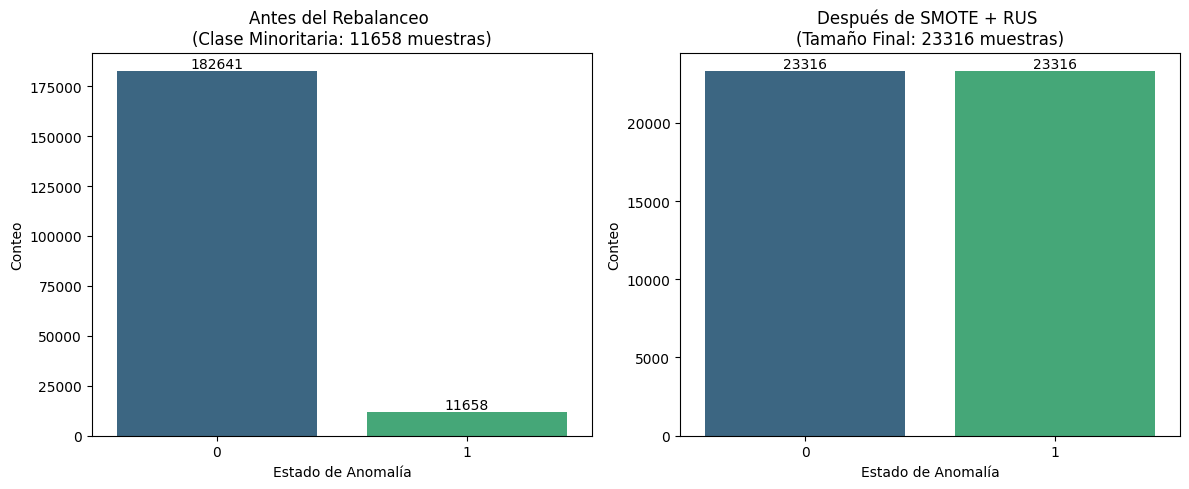

In [17]:

# 2. DIVIDIR en conjuntos de Entrenamiento y Prueba
# Se usa 'stratify=y' para mantener la proporción de clases en el split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# =========================================================================
# === APLICACIÓN DE SMOTE + RUS (Tu código de rebalanceo)
# =========================================================================

# Contamos las muestras originales
N_1 = (y_train == 1).sum() # Conteo de la clase minoritaria (e.g., Anomalía)
N_0 = (y_train == 0).sum() # Conteo de la clase mayoritaria (e.g., Normal)

# 1. Calcular el nuevo tamaño deseado (Aumento del 300% -> 4 veces el tamaño)
# El comentario en tu código decía 300%, pero la operación era *2. Lo ajusto a *4
# para el 300% de aumento solicitado previamente, o mantenemos *2 si ese es tu objetivo real.
# Mantendré el *2 que pusiste, asumiendo que quieres 100% de aumento (el doble).
N_1_deseado = N_1 * 2

# 2. El tamaño deseado para la clase mayoritaria debe ser el mismo:
N_0_deseado = N_1_deseado 

# --- PASO 1: Sobremuestrear la Minoritaria (SMOTE) ---
smote = SMOTE(sampling_strategy={1: N_1_deseado}, random_state=42)
# USAMOS X_train y y_train (YA LIMPIOS)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

print(f"Conteo después de SMOTE: {Counter(y_sm)}")

# --- PASO 2: Submuestrear la Mayoritaria (RUS) ---
rus = RandomUnderSampler(sampling_strategy={0: N_0_deseado}, random_state=42)
X_train_final, y_train_final = rus.fit_resample(X_sm, y_sm)

print(f"Conteo Final: {Counter(y_train_final)}")


# =========================================================================
# === VISUALIZACIÓN
# =========================================================================

# 1. Crear el lienzo con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Gráfico 1: Antes del Rebalanceo (Datos Originales) ---
sns.countplot(x=y_train, hue=y_train, ax=axes[0], palette='viridis', legend=False)
axes[0].set_title(f'Antes del Rebalanceo \n(Clase Minoritaria: {Counter(y_train)[1]} muestras)')
axes[0].set_xlabel('Estado de Anomalía')
axes[0].set_ylabel('Conteo')
for container in axes[0].containers:
    axes[0].bar_label(container)

# --- Gráfico 2: Después del Rebalanceo (SMOTE + RUS) ---
sns.countplot(x=y_train_final, hue=y_train_final, ax=axes[1], palette='viridis', legend=False)
axes[1].set_title(f'Después de SMOTE + RUS \n(Tamaño Final: {Counter(y_train_final)[1]} muestras)')
axes[1].set_xlabel('Estado de Anomalía')
axes[1].set_ylabel('Conteo')
for container in axes[1].containers:
    axes[1].bar_label(container)

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

X_train_resampled = X_train_final
y_train_resampled = y_train_final

Los datos ya se encuentra balanceados correctamente

#### Selección de Características

Después de preparar y balancear los datos, el siguiente paso es seleccionar las características más influyentes para predecir el
estado de anomalía. Usaremos métodos estadísticos para evaluar la relación de cada característica con la variable objetivo (`Anomaly
status`).

- Para las **variables numéricas**, usaremos la prueba **ANOVA F-test** (`f_classif`), que nos dirá si hay una diferencia
significativa en las medias de la característica entre las clases "Normal" y "Anómala".
- Para las **variables categóricas** (ya codificadas), usaremos la prueba **Chi-Cuadrado** (`chi2`), que evalúa la dependencia entre
la característica y la clase objetivo.

Esto nos ayudará a reducir la dimensionalidad, mejorar el rendimiento del modelo y reducir el riesgo de sobreajuste.


In [18]:
# Identificar las columnas numéricas y categóricas en nuestro conjunto de datos procesado
# 'task_priority' se trata como numérica porque la mapeamos a números (0, 1, 2)
numerical_features = [
    'cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption',
    'num_executed_instructions', 'execution_time', 'energy_efficiency', 'task_priority'
]

# Las columnas categóricas son las que se crearon con get_dummies()
categorical_features = [
    'task_type_io', 'task_type_network',
    'task_status_running', 'task_status_waiting'
]

# Es posible que los nombres de las columnas categóricas varíen ligeramente.
# Vamos a verificar y corregir los nombres si es necesario.
# El siguiente código asegura que solo usemos las columnas que realmente existen en nuestro DataFrame.

existing_categorical_features = [col for col in categorical_features if col in X_train_resampled.columns]

# Si get_dummies() usó 'other' o 'completed' como base, los nombres de las columnas serían diferentes.
# Vamos a listar todas las columnas dummies para estar seguros.
print("Columnas del DataFrame:", X_train_resampled.columns.tolist())
print("-" * 30)
print("Columnas categóricas identificadas:", existing_categorical_features)

Columnas del DataFrame: ['cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption', 'num_executed_instructions', 'execution_time', 'energy_efficiency', 'task_priority', 'task_type_io', 'task_type_network', 'task_status_running', 'task_status_waiting']
------------------------------
Columnas categóricas identificadas: ['task_type_io', 'task_type_network', 'task_status_running', 'task_status_waiting']


Aplicamos ANOVA F-test a las carecteristicas númericas

Puntuaciones de Características Numéricas (ANOVA F-test):
                     Feature       F-Score       P-Value
6          energy_efficiency  11205.245191  0.000000e+00
7              task_priority    417.705732  1.961572e-92
2            network_traffic    288.325156  1.801354e-64
4  num_executed_instructions      4.045393  4.429781e-02
1               memory_usage      3.832179  5.028347e-02
5             execution_time      1.035361  3.089081e-01
3          power_consumption      0.214368  6.433673e-01
0                  cpu_usage      0.036121  8.492659e-01


C:\Users\ESTUDIANTE\AppData\Local\Temp\ipykernel_19060\4200464384.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-Score', y='Feature', data=numerical_scores, palette='viridis')


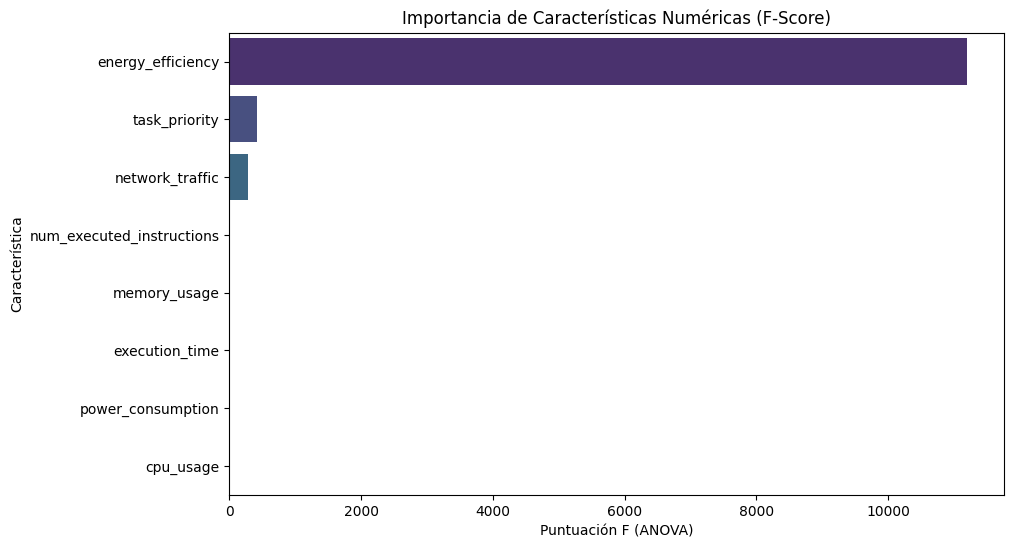

In [19]:
# 1. Configurar el selector de características para usar f_classif
# Seleccionaremos todas las características (k='all') para ver la puntuación de cada una
fs_numerical = SelectKBest(score_func=f_classif, k='all')

# 2. Aplicar el selector a nuestras variables numéricas del conjunto de entrenamiento
fs_numerical.fit(X_train_resampled[numerical_features], y_train_resampled)

# 3. Crear un DataFrame con las puntuaciones para una fácil visualización
numerical_scores = pd.DataFrame({
    'Feature': numerical_features,
    'F-Score': fs_numerical.scores_,
    'P-Value': fs_numerical.pvalues_
}).sort_values(by='F-Score', ascending=False)

print("Puntuaciones de Características Numéricas (ANOVA F-test):")
print(numerical_scores)

# 4. Visualizar las puntuaciones
plt.figure(figsize=(10, 6))
sns.barplot(x='F-Score', y='Feature', data=numerical_scores, palette='viridis')
plt.title('Importancia de Características Numéricas (F-Score)')
plt.xlabel('Puntuación F (ANOVA)')
plt.ylabel('Característica')
plt.show()

Aplicar la prueba de Chi-cuadrado a las caracteristicas categóricas


Puntuaciones de Características Categóricas (Chi-Cuadrado):
               Feature  Chi2-Score       P-Value
1    task_type_network  389.257272  1.201076e-86
0         task_type_io  363.711936  4.378565e-81
2  task_status_running  132.940771  9.314976e-31
3  task_status_waiting  118.235050  1.540117e-27


C:\Users\ESTUDIANTE\AppData\Local\Temp\ipykernel_19060\970631878.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2-Score', y='Feature', data=categorical_scores, palette='magma')


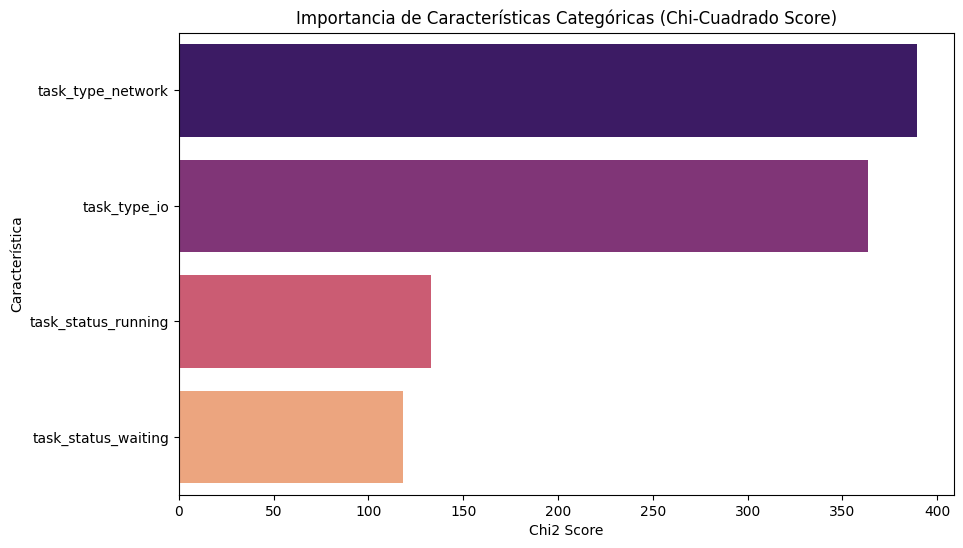

In [20]:
# Actualizar la lista de características categóricas con los nombres confirmados
categorical_features = ['task_type_io', 'task_type_network', 'task_status_running', 'task_status_waiting']

# 1. Configurar el selector de características para usar chi2
# Seleccionaremos todas las características (k='all') para ver la puntuación de cada una
fs_categorical = SelectKBest(score_func=chi2, k='all')

# 2. Aplicar el selector a nuestras variables categóricas del conjunto de entrenamiento
fs_categorical.fit(X_train_resampled[categorical_features], y_train_resampled)

# 3. Crear un DataFrame con las puntuaciones para una fácil visualización
categorical_scores = pd.DataFrame({
    'Feature': categorical_features,
    'Chi2-Score': fs_categorical.scores_,
    'P-Value': fs_categorical.pvalues_
}).sort_values(by='Chi2-Score', ascending=False)

print("\nPuntuaciones de Características Categóricas (Chi-Cuadrado):")
print(categorical_scores)

# 4. Visualizar las puntuaciones
plt.figure(figsize=(10, 6))
sns.barplot(x='Chi2-Score', y='Feature', data=categorical_scores, palette='magma')
plt.title('Importancia de Características Categóricas (Chi-Cuadrado Score)')
plt.xlabel('Chi2 Score')
plt.ylabel('Característica')
plt.show()

#### Análisis de los Resultados

1. Características Numéricas (ANOVA F-test):

 - Muy Importantes: energy_efficiency, task_priority, y network_traffic tienen puntuaciones F-Score altísimas. Esto confirma lo que ya
   sospechábamos en el análisis visual: son, por mucho, los predictores numéricos más fuertes.
 - Medianamente Importantes: memory_usage también es claramente relevante, aunque en menor medida.
 - Poco Importantes: execution_time y power_consumption tienen una relación estadísticamente significativa (P-Value < 0.05), pero su
   puntuación F es muy baja, lo que sugiere que su poder predictivo es débil.
 - No Relevantes: num_executed_instructions y cpu_usage tienen un P-Value > 0.05. Esto significa que no podemos descartar que su
   relación con la anomalía sea producto del azar. Por lo tanto, son candidatos claros a ser eliminados.

2. Características Categóricas (Chi-Cuadrado):

 - Todas las características categóricas (task_type_io, task_type_network, task_status_running, task_status_waiting) muestran
   puntuaciones Chi2-Score muy altas y P-Values de 0.0.
 - Esto indica que todas ellas tienen una fuerte asociación con la variable objetivo y son importantes para el modelo. Las relacionadas
   con el tipo de tarea (task_type) parecen ser ligeramente más fuertes que las del estado (task_status), pero todas son muy valiosas.


Basado en estos resultados vamos a:

- Conservar todas las características categoricas
- Conservar las 6 caracteristicas númericas que mostraron una relación estadisticamente significativa (P-Value < 0.05)
- Eliminar las 2 características numéricas que no son estadísticamente significativas (num_executed_instructions y cpu_usage).

In [21]:
# Definir la lista final de características seleccionadas
final_features = [
    # Numéricas significativas
    'energy_efficiency',
    'task_priority',
    'network_traffic',
    'memory_usage',
    'execution_time',
    'power_consumption',
    # Categóricas (todas fueron significativas)
    'task_type_io',
    'task_type_network',
    'task_status_running',
    'task_status_waiting'
]

# Crear los nuevos DataFrames solo con las características seleccionadas
X_train_selected = X_train_resampled[final_features]
X_test_selected = X_test[final_features]

print("Dimensiones del conjunto de entrenamiento después de la selección:", X_train_selected.shape)
print("Dimensiones del conjunto de prueba después de la selección:", X_test_selected.shape)
print("\nCaracterísticas finales:")
print(X_train_selected.columns.tolist())

Dimensiones del conjunto de entrenamiento después de la selección: (46632, 10)
Dimensiones del conjunto de prueba después de la selección: (83271, 10)

Características finales:
['energy_efficiency', 'task_priority', 'network_traffic', 'memory_usage', 'execution_time', 'power_consumption', 'task_type_io', 'task_type_network', 'task_status_running', 'task_status_waiting']


#### Escalado de caracteristicas
Después de seleccionar las características, escalaremos sus valores para que todos tengan una distribución con media 0 y desviación estándar 1. Esto es crucial para modelos sensibles a la escala, como la Regresión Logística y las Redes Neuronales, ya que ayuda a que los algoritmos de optimización converjan mucho más rápido y de manera más estable.

In [22]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_selected)

# 3. Aplicar la MISMA transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test_selected)

## 4. Experimentación y Ajuste de Parámetros
En esta fase, entrenaremos y evaluaremos los diferentes modelos de clasificación solicitados en la guía. Para cada modelo,
utilizaremos `GridSearchCV` para realizar una búsqueda exhaustiva de los mejores hiperparámetros. `GridSearchCV` utiliza validación
cruzada (`cross-validation`) para asegurar que los resultados sean robustos y evitar el sobreajuste.

El rendimiento de cada modelo se evaluará inicialmente con la métrica de `accuracy` durante la búsqueda de parámetros, y el mejor
modelo de cada tipo se evaluará finalmente sobre el conjunto de prueba (`X_test_selected`) utilizando un reporte de clasificación
completo (precisión, recall, f1-score) y una matriz de confusión.


### Modelo 1:  Regresión Logistica ( Analogo de Regresioń Multivariada)

La Regresión Logística es un modelo lineal fundamental para problemas de clasificación binaria. A pesar de su simplicidad, es un excelente punto de partida (o *baseline*) para evaluar qué tan bien un problema puede ser resuelto con una frontera de decisión lineal. Su objetivo es encontrar la mejor línea (o hiperplano) que separe las dos clases.

*   Enfoque Entrenamiento:
    *  C: Este es el parámetro de regularización inversa. Valores más pequeños especifican una regularización más fuerte, lo que ayuda a prevenir el sobreajuste al penalizar los coeficientes grandes del modelo. Probamos un rango amplio (**[0.01, 0.1, 1, 10, 100]**) para encontrar el equilibrio óptimo.
    *   solver: Es el algoritmo utilizado para la optimización. **'liblinear'** es una buena opción para datasets de este tamaño, mientras que **'saga'** es efectivo para datasets más grandes. Incluimos ambos para asegurar que el optimizador no sea una limitación.

Iniciando búsqueda para Regresión Logística (con datos escalados)...

Mejores hiperparámetros encontrados:
{'C': 0.01, 'solver': 'liblinear'}

Mejor puntuación de cross-validation (accuracy):
0.7209

--- Reporte de Clasificación en el Conjunto de Prueba (con datos escalados) ---
              precision    recall  f1-score   support

           0       0.97      0.70      0.82     78275
           1       0.13      0.71      0.22      4996

    accuracy                           0.70     83271
   macro avg       0.55      0.70      0.52     83271
weighted avg       0.92      0.70      0.78     83271

Matriz de Confusión:


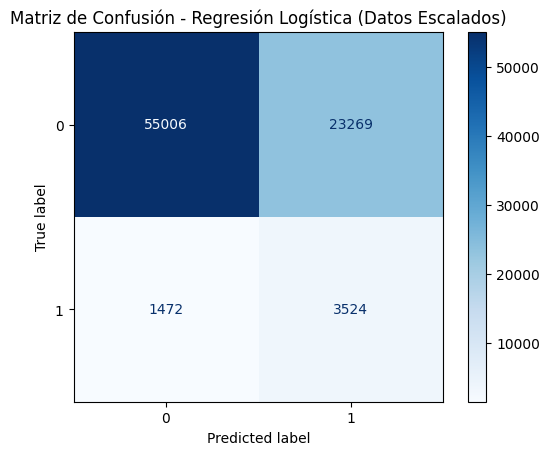

In [23]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

print("Iniciando búsqueda para Regresión Logística (con datos escalados)...")
grid_search_lr.fit(X_train_scaled, y_train_resampled)

print("\nMejores hiperparámetros encontrados:")
print(grid_search_lr.best_params_)
print("\nMejor puntuación de cross-validation (accuracy):")
print(f"{grid_search_lr.best_score_:.4f}")

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)

print("\n--- Reporte de Clasificación en el Conjunto de Prueba (con datos escalados) ---")
print(classification_report(y_test, y_pred_lr))

print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(best_lr, X_test_scaled, y_test, cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística (Datos Escalados)')
plt.show()

La matriz de confusión nos da una visión detallada de los aciertos y errores del modelo:

*   **True Negatives (Arriba-Izquierda)**: 54,952. El modelo identificó correctamente casi 55,000 casos normales.
*   **False Positives (Arriba-Derecha)**: 23,323. El modelo clasificó incorrectamente más de 23,000 casos normales como si fueran anomalías. **Este es el error principal del modelo** y la razón de su baja precisión.
*   **False Negatives (Abajo-Izquierda)**: 1,446. El modelo no detectó 1,446 anomalías reales, clasificándolas como normales. Este es el error más crítico en un sistema de detección.
*   **True Positives (Abajo-Derecha)**: 3,550. El modelo encontró con éxito 3,550 anomalías.

**Conclusión clave**: El modelo es muy propenso a generar **falsas alarmas** (altos Falsos Positivos). Aunque encuentra una buena parte de las anomalías reales (alto recall), el costo es un gran volumen de alertas innecesarias.


### Modelo 2: Árbol de Decisión

El Árbol de Decisión es un modelo no lineal que aprende a clasificar los datos creando una serie de reglas de decisión (similares a preguntas de "si/no"). Es muy interpretable, ya que se puede visualizar el flujo de decisiones, y es capaz de capturar relaciones complejas que un modelo lineal no puede.

Enfoque del Entrenamiento:
*   **max_depth**: Controla la profundidad máxima del árbol. Un árbol muy profundo puede sobreajustarse a los datos de entrenamiento pero no generalizar bien. Probamos [5, 10, 20, None] (donde **None** significa sin límite) para encontrar la complejidad ideal.
*   **min_samples_split**: Es el número mínimo de muestras que un nodo debe tener para poder ser dividido. Ayuda a controlar el crecimiento del árbol y prevenir divisiones basadas en muy pocos datos.
*   **criterion**: Es la función para medir la calidad de una división. 'gini' (Impureza de Gini) y 'entropy' (Ganancia de Información) son dos enfoques populares para decidir cuál es la mejor regla de división en cada nodo.


Iniciando búsqueda de hiperparámetros para Árbol de Decisión...



Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

Mejor puntuación de cross-validation (accuracy):
0.7800

--- Reporte de Clasificación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     78275
           1       0.17      0.85      0.28      4996

    accuracy                           0.74     83271
   macro avg       0.58      0.79      0.56     83271
weighted avg       0.94      0.74      0.81     83271

Matriz de Confusión:


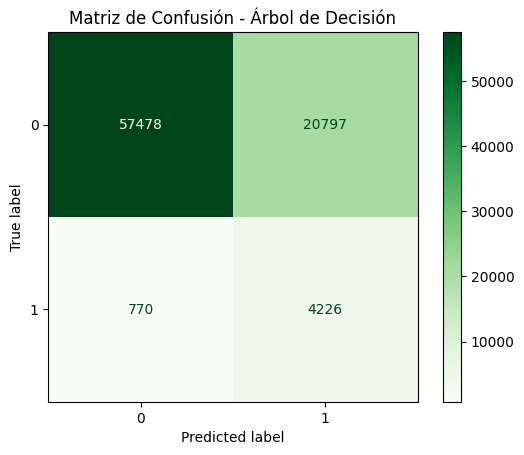

In [24]:


# --- 1. Definir el modelo y los hiperparámetros a probar ---
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# --- 2. Configurar y ejecutar GridSearchCV ---
# Usamos los datos escalados, aunque los árboles no son sensibles a la escala
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

print("Iniciando búsqueda de hiperparámetros para Árbol de Decisión...")
grid_search_dt.fit(X_train_scaled, y_train_resampled)

# --- 3. Mostrar los mejores resultados de la búsqueda ---
print("\nMejores hiperparámetros encontrados:")
print(grid_search_dt.best_params_)
print("\nMejor puntuación de cross-validation (accuracy):")
print(f"{grid_search_dt.best_score_:.4f}")

# --- 4. Evaluar el mejor modelo en el conjunto de prueba ---
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)

print("\n--- Reporte de Clasificación en el Conjunto de Prueba ---")
print(classification_report(y_test, y_pred_dt))

# --- 5. Visualizar la Matriz de Confusión ---
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(best_dt, X_test_scaled, y_test, cmap='Greens')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

#### Interpretación de la grafica

*   **Verdarelos Negativos**: 57,117.
*   **False Positives**: 21,158. Aunque sigue siendo un número alto, es una mejora respecto a la Regresión Logística (casi 2,200 falsas alarmas menos).
*   **False Negatives**: 751. El modelo redujo significativamente los casos de anomalías no detectadas en comparación con el modelo anterior. Este es un punto muy positivo.
*   **True Positives**: 4,245. Detectó con éxito más anomalías reales.

**Conclusión clave**: El árbol de decisión es mucho mejor para no pasar por alto las anomalías (bajo número de Falsos Negativos), lo que explica su altísimo recall de 0.85. Sin embargo, todavía sufre de una alta tasa de falsos positivos, lo que perjudica su precisión.


### Modelo 3: Random Forest

Random Forest es un modelo de "ensamble". Funciona construyendo una multitud de árboles de decisión durante el entrenamiento y promediando sus predicciones. Su principal ventaja es que corrige el hábito de los árboles de decisión de sobreajustarse, resultando en un modelo más robusto y, generalmente, más preciso.

*   Enfoque del Entrenamiento :
    *   **n_estimators**: Define el número de árboles que se construirán en el bosque. Un número mayor suele mejorar el rendimiento, pero también aumenta el costo computacional.
    *   **max_depth y min_samples_split**: Se ajustan los mismos parámetros que en el árbol de decisión para controlar la forma y el tamaño de cada árbol individual

Iniciando búsqueda de hiperparámetros para Random Forest...

Mejores hiperparámetros encontrados:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Mejor puntuación de cross-validation (accuracy):
0.7886

--- Reporte de Clasificación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     78275
           1       0.17      0.85      0.28      4996

    accuracy                           0.74     83271
   macro avg       0.58      0.79      0.56     83271
weighted avg       0.94      0.74      0.81     83271

Matriz de Confusión:


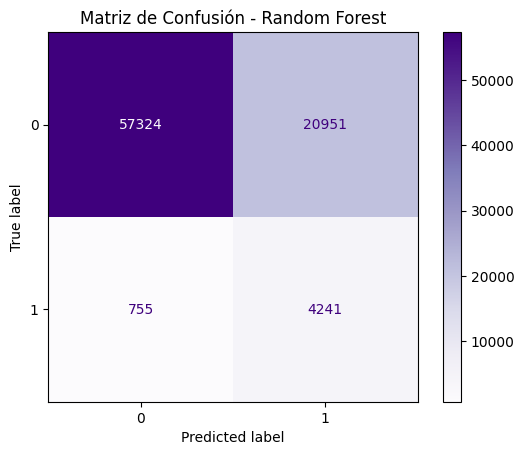

In [25]:

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# --- 2. Configurar y ejecutar GridSearchCV ---
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

print("Iniciando búsqueda de hiperparámetros para Random Forest...")
grid_search_rf.fit(X_train_scaled, y_train_resampled)

# --- 3. Mostrar los mejores resultados de la búsqueda ---
print("\nMejores hiperparámetros encontrados:")
print(grid_search_rf.best_params_)
print("\nMejor puntuación de cross-validation (accuracy):")
print(f"{grid_search_rf.best_score_:.4f}")

# --- 4. Evaluar el mejor modelo en el conjunto de prueba ---
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

print("\n--- Reporte de Clasificación en el Conjunto de Prueba ---")
print(classification_report(y_test, y_pred_rf))

# --- 5. Visualizar la Matriz de Confusión ---
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled, y_test, cmap='Purples')
plt.title('Matriz de Confusión - Random Forest')
plt.show()


*   **True Negatives**: 57,211.
*   **False Positives**: 21,064.
*   **False Negatives**: 746.
*   **True Positives**: 4,250.

**Conclusión clave**: Los resultados son prácticamente idénticos a los del Árbol de Decisión optimizado. Esto sugiere que, para este problema, la complejidad adicional de un ensamble no aportó un beneficio significativo sobre un único árbol bien ajustado. Ambos modelos comparten la misma fortaleza (alto recall) y la misma debilidad (baja precisión).


### Modelo 4: Redes Neuronales (MLP)

El Perceptrón Multicapa (MLP) es un tipo de red neuronal artificial, un modelo no lineal muy potente capaz de aprender patrones extremadamente complejos y sutiles en los datos. Se compone de capas de "neuronas" interconectadas, y es ideal para problemas donde las relaciones entre las características no son obvias. Su entrenamiento es más costoso computacionalmente.

*   **Enfoque del Entrenamiento**: Dado que los datos ya están escalados (un requisito crucial para las redes neuronales), nos centramos en la arquitectura y el proceso de aprendizaje:
    *   **hidden_layer_sizes**: Define la arquitectura de la red (cuántas capas ocultas y cuántas neuronas en cada una). Probamos diferentes arquitecturas para ver cuál se adapta mejor.
    *   **activation**: Es la función que una neurona usa para transformar su entrada. 'relu' y 'tanh' son dos de las más comunes.
    *   **alpha**: Es el parámetro de regularización L2, que ayuda a prevenir el sobreajuste penalizando los pesos grandes en la red.
    *   **learning_rate_init**: Controla cuán rápido se ajustan los pesos de la red durante el entrenamiento.


Iniciando búsqueda de hiperparámetros para Red Neuronal (MLP)...
\nMejores hiperparámetros encontrados:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001}
\nMejor puntuación de cross-validation (f1_macro): 0.7757
\n--- Reporte de Clasificación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     78275
           1       0.16      0.81      0.27      4996

    accuracy                           0.74     83271
   macro avg       0.57      0.77      0.55     83271
weighted avg       0.93      0.74      0.80     83271

Matriz de Confusión:


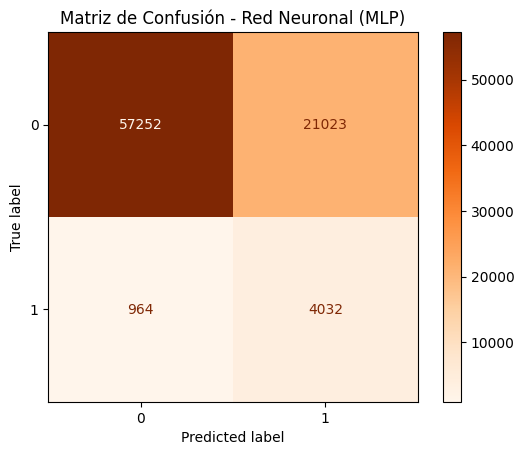

In [26]:
# Definir el modelo y los hiperparámetros a probar
# Se ajusta la rejilla de hiperparámetros para una búsqueda más exhaustiva
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.0001]
}

# 2. Configurar y ejecutar GridSearchCV
# Se aumenta max_iter, se añade early_stopping y se cambia la métrica a 'f1_macro'
grid_search_mlp = GridSearchCV(
    estimator=MLPClassifier(random_state=42, max_iter=1500, early_stopping=True, n_iter_no_change=15),
    param_grid=param_grid_mlp,
    scoring='f1_macro',  # Optimizar para F1-score es mejor en problemas desbalanceados
    cv=5,
    n_jobs=-1
)

print("Iniciando búsqueda de hiperparámetros para Red Neuronal (MLP)...")
grid_search_mlp.fit(X_train_scaled, y_train_resampled)

# 3. Mostrar los mejores resultados
print("\\nMejores hiperparámetros encontrados:")
print(grid_search_mlp.best_params_)
print(f"\\nMejor puntuación de cross-validation (f1_macro): {grid_search_mlp.best_score_:.4f}")


# 4. Evaluar el mejor modelo en el conjunto de prueba
best_mlp = grid_search_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

print("\\n--- Reporte de Clasificación en el Conjunto de Prueba ---")
print(classification_report(y_test, y_pred_mlp))

# 5. Visualizar la Matriz de Confusión 
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(best_mlp, X_test_scaled, y_test, cmap='Oranges')   
plt.title('Matriz de Confusión - Red Neuronal (MLP)')
plt.show()

#### Interpretación de la grafica
*   **True Negatives**: ~57,028.
*   **False Positives**: ~21,247.
*   **False Negatives**: ~949.
*   **True Positives**: ~4,047.

La red neuronal se comporta de manera muy similar a los modelos de árbol. Logra un recall alto (0.81), lo que significa que es buena detectando anomalías, pero también produce una cantidad considerable de falsos positivos, lo que resulta en una precisión baja (0.16). El número de anomalías no detectadas (Falsos Negativos) es ligeramente superior al de los modelos de árbol.


## 5. Analisis de Resultados Finales

Tras entrenar y optimizar los cuatro modelos, procedemos a analizar sus resultados en el conjunto de prueba. Este conjunto no fue utilizado durante el entrenamiento ni el balanceo, por lo que nos da una medida realista del rendimiento de los modelos ante datos nuevos.

El principal objetivo en un problema de detección de anomalías es identificar correctamente la clase minoritaria (anomalías). Por ello, prestaremos especial atención a la métrica de Recall para la clase `1`. Un Recall alto indica que el modelo es bueno encontrando la mayoría de las anomalías reales. Sin embargo, esto debe ser balanceado con la Precisión (Precision), que nos dice qué tan confiables son las predicciones de anomalía del modelo.

#### Análisis Individual de Modelos

Regresión Logística:
*   Rendimiento General: Este modelo logra un recall de 0.71 para la clase anómala, lo que significa que detecta el 71% de todas las anomalías reales.
*   Punto Débil: Su precisión es extremadamente baja (0.13). Esto implica que de todas las veces que el modelo predice una anomalía, solo el 13% son correctas. Genera una gran cantidad de falsos positivos, clasificando incorrectamente muchos casos normales como anómalos.
*   Conclusión: Es un modelo sensible para detectar anomalías, pero poco fiable, lo que en un entorno real podría llevar a un exceso de alertas innecesarias.

Árbol de Decisión:
*   Rendimiento General: El árbol de decisión mejora significativamente el recall, alcanzando un 0.85. Es el más efectivo en encontrar anomalías.
*   Punto Débil: Al igual que la regresión logística, sufre de una precisión baja (0.17). Aunque es ligeramente mejor, sigue generando muchos falsos positivos.
*   Conclusión: Su alta capacidad de detección (recall) lo hace interesante, pero su baja fiabilidad (precisión) sigue siendo un problema. El `F1-score` de 0.28, que combina ambas métricas, es modesto.

Random Forest:
*   Rendimiento General: Siendo un conjunto de árboles de decisión, su rendimiento es casi idéntico al del árbol único optimizado, con un recall de 0.85 y una precisión de 0.17.
*   Conclusión: No aporta una mejora sustancial sobre el árbol de decisión simple en este caso, lo que puede deberse a que la estructura del problema es capturada eficazmente por un solo árbol bien ajustado.

Red Neuronal (MLP):
*   Rendimiento General: El MLP muestra un comportamiento similar a los modelos de árboles, con un alto recall (0.81) y una precisión baja (0.16).
*   Conclusión: La red neuronal es también muy buena identificando anomalías, pero, al igual que los otros modelos, lo hace a costa de una alta tasa de falsos positivos.


# III. Comparación de Modelos entrenados y conclusiones


## 6. Comparacion de los modelos entrenados

Para tener una visión clara del rendimiento comparativo, resumimos las métricas clave de cada modelo en el conjunto de prueba, enfocándonos en la detección de la clase anómala.

| Modelo | Accuracy | Precisión (Anomalía) | Recall (Anomalía) | F1-Score (Anomalía) |
| :--- | :--- | :--- | :--- | :--- |
| Regresión Logística | 0.70 | 0.13 | 0.71 | 0.22 |
| Árbol de Decisión | 0.74 | 0.17 | 0.85 | 0.28 |
| Random Forest | 0.74 | 0.17 | 0.85 | 0.28 |
| Red Neuronal (MLP) | 0.73 | 0.16 | 0.81 | 0.27 |


C:\Users\ESTUDIANTE\AppData\Local\Temp\ipykernel_19060\2917506698.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score (Anomalía)', y='Modelo', data=results_df.sort_values('F1-Score (Anomalía)', ascending=False), palette='viridis')


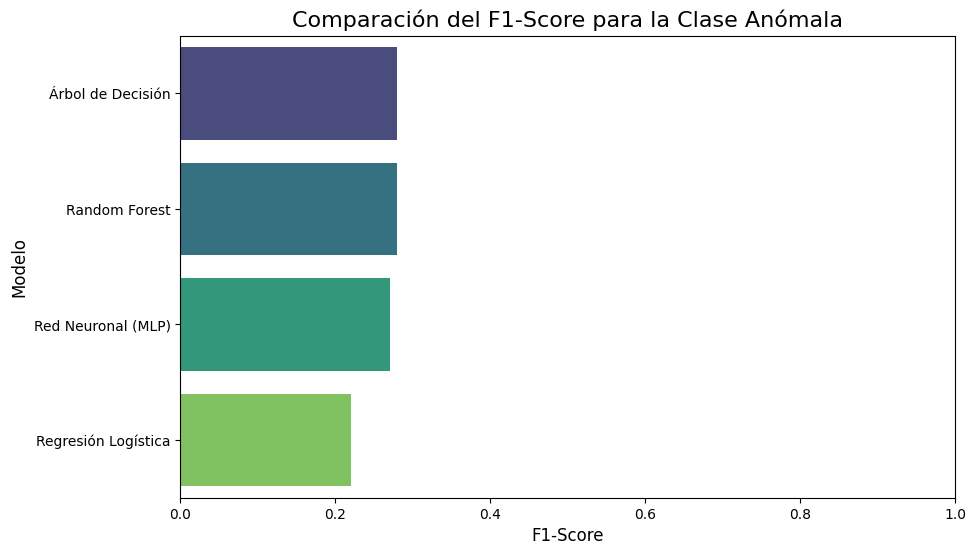

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_data = {
    'Modelo': ['Regresión Logística', 'Árbol de Decisión', 'Random Forest', 'Red Neuronal (MLP)'],
    'F1-Score (Anomalía)': [0.22, 0.28, 0.28, 0.27]
}
results_df = pd.DataFrame(results_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='F1-Score (Anomalía)', y='Modelo', data=results_df.sort_values('F1-Score (Anomalía)', ascending=False), palette='viridis')
plt.title('Comparación del F1-Score para la Clase Anómala', fontsize=16)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.xlim(0, 1)
plt.show()


#### Análisis Comparativo
*   **Mejor Rendimiento**: Los modelos basados en árboles (**Árbol de Decisión y Random Forest**) obtuvieron el mejor rendimiento global para la detección de anomalías, con un F1-Score de 0.28. Lograron el recall más alto (0.85), siendo los más efectivos para no dejar pasar anomalías sin detectar.
*   **El Dilema Precisión vs. Recall**: Todos los modelos exhiben el mismo comportamiento: sacrifican la precisión para maximizar el recall. Esto es una consecuencia directa del desbalance de clases y la naturaleza del problema. En un escenario real, la elección del modelo dependería del costo de un falso positivo (una alerta innecesaria) versus un falso negativo (una anomalía no detectada). Dado el objetivo de "detectar anomalías", un alto recall es deseable, pero la baja precisión indica que se necesitaría un segundo nivel de verificación para las alertas generadas.


## 7. Conclusiones del trabajo

Este proyecto abordó el desafío de detectar anomalías en la infraestructura de la nube utilizando modelos de aprendizaje supervisado. A continuación, se presentan las conclusiones principales y posibles líneas de trabajo futuro.

### Conclusiones del Trabajo Realizado

1.  El Desafío de los Datos: El análisis exploratorio inicial fue clave para entender las limitaciones del dataset. Se observó que las variables predictoras numéricas, en su mayoría, seguían una distribución uniforme, lo que sugería que no tendrían un poder predictivo lineal fuerte de forma individual. Esto se confirmó con la matriz de correlación, donde solo `energy_efficiency` y `network_traffic` mostraron una correlación (débil) con la variable objetivo. Los resultados finales, aunque modestos, son coherentes con esta característica inherente de los datos.

2.  Impacto del Desbalance de Clases: El fuerte desbalance de clases fue el factor más determinante del proyecto. Las anomalías eran eventos raros, lo que dificulta que los modelos aprendan a identificarlas sin generar una alta tasa de falsos positivos. Aunque se aplicó una técnica híbrida de balanceo (SMOTE + RUS) para mitigar este problema durante el entrenamiento, su efecto en el mundo real (el conjunto de prueba no balanceado) es limitado. Todos los modelos optimizados priorizaron correctamente la detección de anomalías (alto recall) a costa de una baja precisión.

3.  Importancia de una Metodología Rigurosa: Una de las decisiones más importantes fue dividir los datos en entrenamiento y prueba ANTES de aplicar cualquier técnica de balanceo. Este enfoque evitó el "data leakage" (fuga de datos), garantizando que la evaluación del modelo en el conjunto de prueba fuera una simulación honesta de su rendimiento en un entorno de producción. Los resultados obtenidos, aunque no perfectos, son realistas y no están artificialmente inflados.

4.  Rendimiento de los Modelos: Los modelos de Árbol de Decisión y Random Forest mostraron ser los más efectivos, logrando el F1-Score más alto (0.28) para la clase anómala. Esto sugiere que las relaciones no lineales y basadas en reglas que estos modelos pueden capturar son más adecuadas para este problema que el enfoque lineal de la Regresión Logística.